<a href="https://colab.research.google.com/github/Kinadim/ML_projet/blob/main/ML_PROJET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

## Importation des différentes librairies utiles pour le notebook

In [29]:
!pip install pyspark deep-translator mlutils XGBoost


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from deep_translator import GoogleTranslator

import itertools
import re
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
from xgboost import XGBClassifier

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

from sklearn.preprocessing import StandardScaler, KBinsDiscretizer, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score,ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

import pyspark
from pyspark.ml.linalg import Matrices
from pyspark.mllib.util import MLUtils

Defaulting to user installation because normal site-packages is not writeable


### Affichage du dataset

In [2]:
df=pd.read_csv('scitweets_export.tsv', sep='\t')
display (df.head())
display(df.info())
display(df.describe())

,Unnamed: 0,tweet_id,text,science_related,scientific_claim,scientific_reference,scientific_context
0,0,316669998137483264,Knees are a bit sore. i guess that's a sign th...,0,0.0,0.0,0.0
1,1,319090866545385472,McDonald's breakfast stop then the gym 🏀💪,0,0.0,0.0,0.0
2,2,322030931022065664,Can any Gynecologist with Cancer Experience ex...,1,1.0,0.0,0.0
3,3,322694830620807168,Couch-lock highs lead to sleeping in the couch...,1,1.0,0.0,0.0
4,4,328524426658328576,Does daily routine help prevent problems with ...,1,1.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1140 entries, 0 to 1139
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            1140 non-null   int64  
 1   tweet_id              1140 non-null   int64  
 2   text                  1140 non-null   object 
 3   science_related       1140 non-null   int64  
 4   scientific_claim      1140 non-null   float64
 5   scientific_reference  1140 non-null   float64
 6   scientific_context    1140 non-null   float64
dtypes: float64(3), int64(3), object(1)
memory usage: 62.5+ KB


None

,Unnamed: 0,tweet_id,science_related,scientific_claim,scientific_reference,scientific_context
count,1140.000000,1.140000e+03,1140.000000,1140.000000,1140.00000,1140.000000
mean,626.040351,8.560901e+17,0.328947,0.230702,0.17807,0.220175
std,364.412255,2.865422e+17,0.470037,0.421467,0.38274,0.414547
min,0.000000,3.166700e+17,0.000000,0.000000,0.00000,0.000000
25%,306.750000,6.176042e+17,0.000000,0.000000,0.00000,0.000000
50%,624.500000,8.615253e+17,0.000000,0.000000,0.00000,0.000000
75%,940.250000,1.103864e+18,1.000000,0.000000,0.00000,0.000000
max,1260.000000,1.344485e+18,1.000000,1.000000,1.00000,1.000000


### On observe la répartition des valeurs pour chaque classe

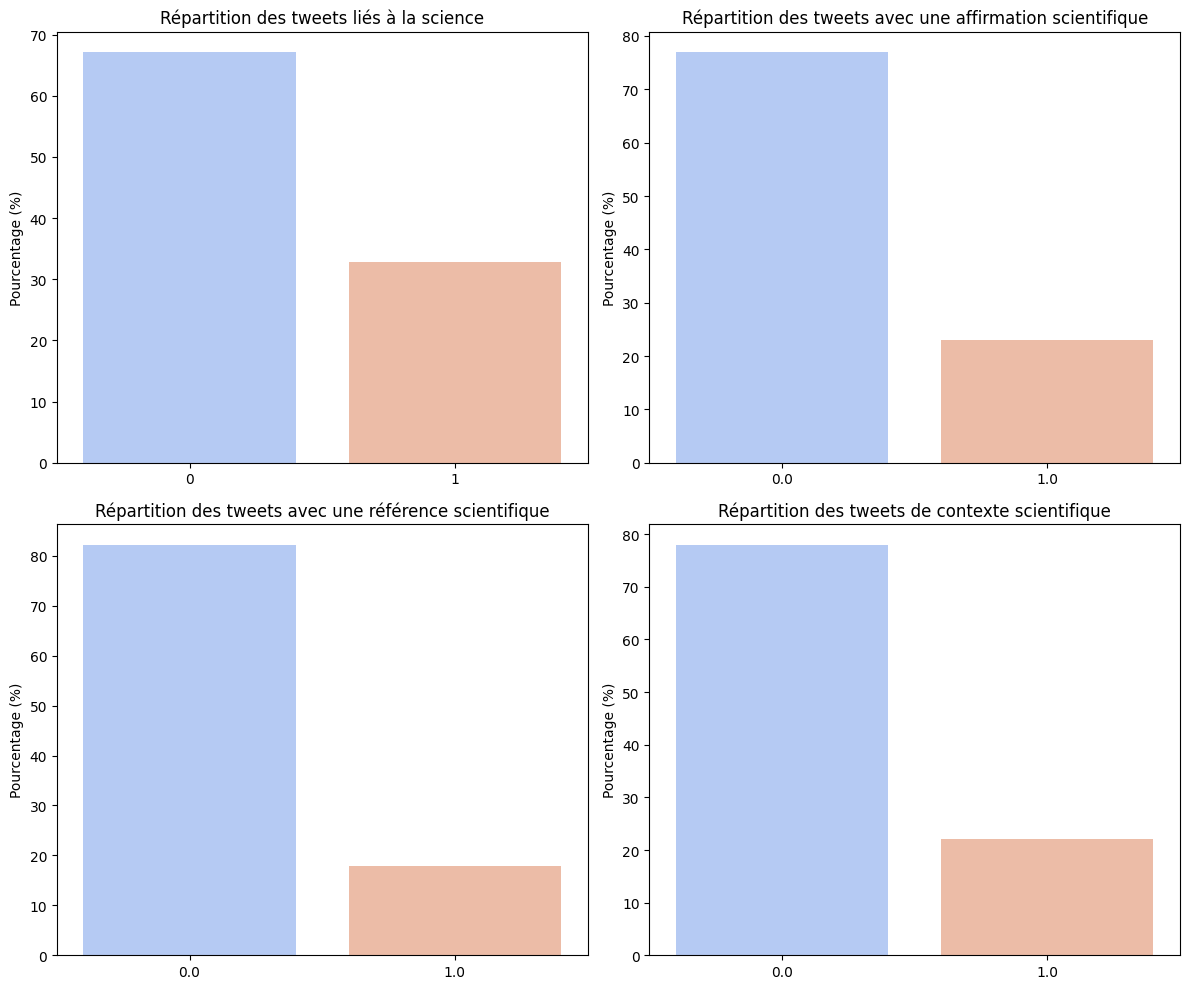

In [3]:
# Définir la figure avec 2 lignes et 2 colonnes
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Liste des colonnes à afficher
columns = ['science_related', 'scientific_claim', 'scientific_reference', 'scientific_context']
titles = [
    "Répartition des tweets liés à la science",
    "Répartition des tweets avec une affirmation scientifique",
    "Répartition des tweets avec une référence scientifique",
    "Répartition des tweets de contexte scientifique"
]

# Générer les 4 countplots avec pourcentage
for ax, col, title in zip(axes.flat, columns, titles):
    total = len(df[col])  # Nombre total d'observations
    sns.barplot(
        x=df[col].value_counts(normalize=True).index,  # Valeurs uniques
        y=df[col].value_counts(normalize=True).values * 100,  # Pourcentage
        ax=ax, palette="coolwarm"
    )
    ax.set_title(title)
    ax.set_xlabel("")  # Supprimer les labels des axes X pour plus de lisibilité
    ax.set_ylabel("Pourcentage (%)")

# Ajuster l'espacement
plt.tight_layout()
plt.show()


On remarque que la majorité des tweets de notre dataset d'entrainement ne sont pas scientifiques

## Séparation en 2 classes : Scientifique vs Non scientifique

Dans un premier temps il s'agit d'effectuer des pré traitement sur les données afin d'améliorer les prédictions des modèles par la suite

On a remarqué que certains tweets utilise des mots qui ne sont pas en anglais, du coréen notamment. Il parait donc approprié de traduire les tweets en anglais pour que modèle ne soit pas biaisé par la présence de différentes langues "outliers" dans le dataset qui viendrait influer négativement sur nos résultats. Pour pallier à ce problème nous utilisons les fonctionnalité de traduction proposé par Google Traduction. 

### Fonction pour traduire en anglais

In [53]:
def translate_to_english(tweet):
    translated = GoogleTranslator(source='auto', target='en').translate(tweet)
    return translated
df['text'] = df['text'].apply(translate_to_english)

KeyboardInterrupt: 

Dans un second temps nous générons toutes les combinaisons de nettoyage de données afin de déterminer lesquelles sont intéressantes:
- Suppression des hyperliens
- Suppression des mentions d'utilisateurs
- Suppression des hashtags
- Texte transformé en miniscule
- Suppression de la ponctuation
- Suppression des stop words(mots trop communs ayant aucune utilité sémantique)
- Lemmatisation des mots, on transforme les mots en leur forme racine(making devient make par exemple), en s'assurant qu'ils conservent leur sens grâce à un dictionnaire de lemme existants
- Racinisation des mots, on transforme les mots en leur forme racine sans s'assurer que le mot produit est un terme existant

In [39]:
# Télécharger les ressources nécessaires
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')
# Charger les données

# Définition des fonctions de prétraitement
def remove_links(tweet):
    return re.sub(r'http\S+|www\S+|https\S+|\@\w+|\#', '', tweet, flags=re.MULTILINE)

def remove_mentions(tweet):
    return re.sub(r'\@\w+', '', tweet, flags=re.MULTILINE)

def remove_hashtags(tweet):
    return re.sub(r'\#+', '', tweet, flags=re.MULTILINE)

def to_lowercase(tweet):
    return tweet.lower()

def remove_punctuation(tweet):
    return re.sub(r'[^\w\s]', '', tweet)

def remove_stopwords(tweet):
    tokens = word_tokenize(tweet)
    return ' '.join([word for word in tokens if word not in stopwords.words('english')])

def lemmatize_words(tweet):
    tokens = word_tokenize(tweet)
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word) for word in tokens])

def stem_words(tweet):
    tokens = word_tokenize(tweet)
    stemmer = PorterStemmer()
    return ' '.join([stemmer.stem(word) for word in tokens])


# Liste des transformations possibles
transformations = {
    "remove_links": remove_links,
    "to_lowercase": to_lowercase,
    "remove_punctuation": remove_punctuation,
    "remove_stopwords": remove_stopwords,
    "lemmatize_words": lemmatize_words,
    "remove_mentions": remove_mentions,
    "remove_hashtags": remove_hashtags,
    "stem_words": stem_words
}

# Générer toutes les combinaisons possibles des transformations
all_combinations = []
for i in range(1, len(transformations) + 1):
    all_combinations.extend(itertools.combinations(transformations.keys(), i))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/clementwt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/clementwt/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/clementwt/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/clementwt/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Il s'agit ensuite de déterminer pour ces combinaisons quel modèle est le plus performant, nous allons donc tester toutes les combinaisons pour chaque modèle

In [47]:
# === Modèles à tester ===
models = {
    "Régression Logistique": LogisticRegression(class_weight='balanced', max_iter=1000),
    "SVM Linéaire": LinearSVC(class_weight='balanced', max_iter=3000),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=5631),
    "Naive Bayes": MultinomialNB(),
    "XGBoost": XGBClassifier(eval_metric='logloss'),
    "Perceptron Multicouche": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)
}
# Stocker les résultats
results = []

# === Boucle principale ===
for i, combo in enumerate(all_combinations):
    df_copy = df.copy()

    # Appliquer toutes les transformations de la combinaison
    for transform_name in combo:
        df_copy['text'] = df_copy['text'].apply(transformations[transform_name])

    # Données texte + labels
    X = df_copy['text']
    y = df_copy['science_related']

    # TF-IDF
    vectorizer = TfidfVectorizer()
    X_vect = vectorizer.fit_transform(X)

    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.2, random_state=42)

    # Tester chaque modèle
    for model_name, model in models.items():
        pipeline = make_pipeline(StandardScaler(with_mean=False), model)
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        acc = accuracy_score(y_test, y_pred)

        results.append({
            "combination": combo,
            "model_name": model_name,
            "accuracy": acc,
            "y_test": y_test,
            "y_pred": y_pred
        })

        print(f"[{i+1}/{len(all_combinations)}] Combo: {combo} | Model: {model_name} | Acc: {acc:.4f}")


[1/255] Combo: ('remove_links',) | Model: Régression Logistique | Acc: 0.7675
[1/255] Combo: ('remove_links',) | Model: SVM Linéaire | Acc: 0.7588
[1/255] Combo: ('remove_links',) | Model: Random Forest | Acc: 0.7149
[1/255] Combo: ('remove_links',) | Model: Gradient Boosting | Acc: 0.7632
[1/255] Combo: ('remove_links',) | Model: Decision Tree | Acc: 0.7500
[1/255] Combo: ('remove_links',) | Model: Naive Bayes | Acc: 0.7368
[1/255] Combo: ('remove_links',) | Model: XGBoost | Acc: 0.7719
[1/255] Combo: ('remove_links',) | Model: Perceptron Multicouche | Acc: 0.7281
[2/255] Combo: ('to_lowercase',) | Model: Régression Logistique | Acc: 0.7675
[2/255] Combo: ('to_lowercase',) | Model: SVM Linéaire | Acc: 0.7632
[2/255] Combo: ('to_lowercase',) | Model: Random Forest | Acc: 0.6974
[2/255] Combo: ('to_lowercase',) | Model: Gradient Boosting | Acc: 0.7939
[2/255] Combo: ('to_lowercase',) | Model: Decision Tree | Acc: 0.7632
[2/255] Combo: ('to_lowercase',) | Model: Naive Bayes | Acc: 0.7281

On peut observer que plus haute accuracy concernent 3-4 modèles qui atteignent un résultat similaire, XGBoost, Decision Tree, Random Forest et Gradient Boosting 

Prenons par exemple le meilleur modèle associé à sa combinaison de pré traitement afin d'en observer les résultats plus en détail

In [51]:
# Convertir les résultats en DataFrame pour manipulation facile
results_df = pd.DataFrame(results)

# Trouver la meilleure combinaison pour chaque modèle
best_per_model = results_df.loc[results_df.groupby("model")["accuracy"].idxmax()]

# Afficher joliment
print("\n=== Meilleures combinaisons par modèle ===")
print(best_per_model.sort_values(by="accuracy", ascending=False).to_string(index=False))


=== Meilleures combinaisons par modèle ===
                                                                                                     combination                  model  accuracy
                                                                                   (remove_mentions, stem_words)                XGBoost  0.815789
                                                                  (remove_links, to_lowercase, remove_stopwords)          Decision Tree  0.811404
(remove_links, to_lowercase, remove_punctuation, remove_stopwords, lemmatize_words, remove_mentions, stem_words)          Random Forest  0.811404
                                                                                      (to_lowercase, stem_words)      Gradient Boosting  0.802632
                                                                  (remove_links, remove_punctuation, stem_words)  Régression Logistique  0.793860
                                                                  (remove_links,


 Meilleur modèle : XGBoost
 Meilleure combinaison de transformations : ('remove_mentions', 'stem_words')
 Accuracy : 0.8158

Classification Report :

              precision    recall  f1-score   support

           0       0.82      0.92      0.86       146
           1       0.81      0.63      0.71        82

    accuracy                           0.82       228
   macro avg       0.81      0.78      0.79       228
weighted avg       0.82      0.82      0.81       228

Matrice de confusion :


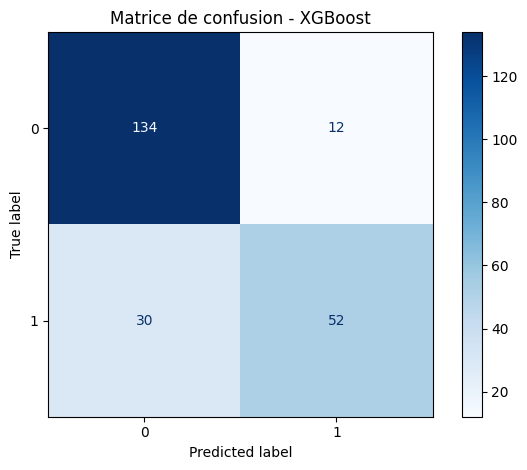

In [52]:
# ------------------ Affichage du meilleur modèle ------------------

results_df = pd.DataFrame(results)
best_result = results_df.loc[results_df["accuracy"].idxmax()]

print("\nMeilleur résultat :")
print(f"Modèle     : {best_result['model_name']}")
print(f"Combo      : {best_result['combination']}")
print(f"Accuracy   : {best_result['accuracy']:.4f}")

# Rapport + matrice de confusion
print("\nClassification Report:")
print(classification_report(best_result["y_test"], best_result["y_pred"]))

print("Matrice de confusion :")
cm = confusion_matrix(best_result["y_test"], best_result["y_pred"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")
plt.title(f"Confusion Matrix - {best_result['model_name']}")
plt.tight_layout()
plt.show()

On remarque peu de faux négatif et de faux positif et à l'inverse beaucoup de vrai positif et vrai négatif ce qui veut dire que le modèle fait peu d'erreurs et réussit à bien identifier les classes

## Séparation en 2 classes : (CLAIM et REF) vs CONTEXT

Dans cette partie visant à séparer en deux classes (CLAIM et REF) vs CONTEXT les tweets, on ne s'intéresse qu'aux tweets scientifiques, le dataset utilisé n'a donc aucun tweets non scientifique

En exécutant le code ci-dessous une première fois sans modification sur les échantillons, on se rend compte que il y a un fort déséquilibre entre les classes dans notre échantillon ce qui fausse totalement les résultats.
On a donc essayé de rajouter de l'upsampling qui permet de rajouter des données crédibles, et d'éviter que notre modèle ne privilégie la classe majoritaire juste parce qu’elle est surreprésentée.
Mais le jeu de test est aussi très petit ce qui rend difficile l'évaluation de nos modèles

In [102]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Étape 1 : préparer les données
sci_df = df[df['science_related'] == 1].copy()
task2_df = sci_df.copy()
task2_df['label'] = task2_df[['scientific_claim', 'scientific_reference']].max(axis=1)


X = task2_df["text"]
y = task2_df["label"]

# Vectorisation
vectorizer = TfidfVectorizer()
X_vect = vectorizer.fit_transform(X)

# Split initial
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.3, random_state=42, stratify=y)

# Appliquer RandomOverSampler pour augmenter les données
ros = RandomOverSampler(sampling_strategy={0.0: 256, 1.0: 256}, random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

# Afficher le nombre d'exemples avant et après suréchantillonnage
print("Classe avant suréchantillonnage:", y_train.value_counts())
print("Classe après suréchantillonnage:", y_train_res.value_counts())

# Tester tous les modèles avec le suréchantillonnage
for model_name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)

    task2_results.append({
        "model_name": model_name,
        "f1_score": f1,
        "y_test": y_test,
        "y_pred": y_pred,
        "model": model,
        "vectorizer": vectorizer,
        "X_train": X_train,
        "X_test": X_test
    })

    print(f"{model_name} => F1-Score: {f1:.4f}")




Classe avant suréchantillonnage: label
1.0    239
0.0     23
Name: count, dtype: int64
Classe après suréchantillonnage: label
1.0    256
0.0    256
Name: count, dtype: int64
Régression Logistique => F1-Score: 0.9537
SVM Linéaire => F1-Score: 0.9537
Random Forest => F1-Score: 0.9537
Gradient Boosting => F1-Score: 0.9619
Decision Tree => F1-Score: 0.9109
Naive Bayes => F1-Score: 0.8912
XGBoost => F1-Score: 0.9333
Perceptron Multicouche => F1-Score: 0.9533


In [103]:
# Trier les résultats par F1-Score en ordre décroissant
best_result = sorted(task2_results, key=lambda x: x['f1_score'], reverse=True)[0]

# Afficher les résultats du meilleur modèle
print(f"Meilleur Modèle : {best_result['model_name']}")
print(f"F1-Score     : {best_result['f1_score']:.4f}")
print("Classification Report:")
print(classification_report(best_result['y_test'], best_result['y_pred']))

Meilleur Modèle : Gradient Boosting
F1-Score     : 0.9619
Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      0.40      0.50        10
         1.0       0.94      0.98      0.96       103

    accuracy                           0.93       113
   macro avg       0.81      0.69      0.73       113
weighted avg       0.92      0.93      0.92       113



## Séparation en 3 classes : CLAIM vs REF vs CONTEXT

Je sais pas c'est quoi le truc ci dessous sah jvais pas y toucher

In [ ]:


# Supposons que df soit déjà chargé avec les données du fichier TSV
# df = pd.read_csv('scitweets_export.tsv', sep='\t')

# Fonction pour extraire les caractéristiques spécifiques (présence de #, @, liens)
def extract_features(text):
    has_hashtag = 1 if '#' in text else 0
    has_at = 1 if '@' in text else 0
    # Recherche de liens avec regex
    has_link = 1 if bool(re.search(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', text)) else 0
    # Recherche de "t.co" qui est un raccourcisseur d'URL souvent utilisé par Twitter
    has_tco = 1 if 't.co' in text else 0
    
    return pd.Series([has_hashtag, has_at, has_link, has_tco])

def classify_scientific_reference():
    # Extraction des caractéristiques
    df[['has_hashtag', 'has_at', 'has_link', 'has_tco']] = df['text'].apply(extract_features)
    
    # Sélection des caractéristiques et de la cible
    features = df[['has_hashtag', 'has_at', 'has_link', 'has_tco']]
    target = df['scientific_reference'].fillna(0)  # Remplacer les NaN par 0 pour éviter les erreurs
    
    # Division des données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
    
    # Création et entraînement du modèle
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train, y_train)
    
    # Prédictions
    y_pred = model.predict(X_test)
    
    # Évaluation des performances
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    print(f"Performance du modèle avec les caractéristiques spécifiques:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Afficher le rapport de classification détaillé
    print("\nRapport de classification:")
    print(classification_report(y_test, y_pred))
    
    # Afficher la matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Matrice de confusion')
    plt.xlabel('Prédiction')
    plt.ylabel('Réalité')
    plt.show()
    
    # Afficher l'importance des caractéristiques
    importances = model.feature_importances_
    feature_names = ['has_hashtag', 'has_at', 'has_link', 'has_tco']
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_names, y=importances)
    plt.title('Importance des caractéristiques')
    plt.xlabel('Caractéristique')
    plt.ylabel('Importance')
    plt.show()
    
    return model

# Fonction pour comparer avec une approche utilisant TF-IDF pour compléter l'analyse
def compare_with_tfidf():
    # Préparation des données
    X = df['text']
    y = df['scientific_reference'].fillna(0)
    
    # Division des données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Extraction de caractéristiques avec TF-IDF
    vectorizer = CountVectorizer(max_features=100)  # Limiter à 100 mots les plus fréquents
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    
    # Création et entraînement du modèle
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train_tfidf, y_train)
    
    # Prédictions
    y_pred = model.predict(X_test_tfidf)
    
    # Évaluation des performances
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    print(f"\nPerformance du modèle avec TF-IDF:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

# Fonction pour combiner les deux approches
def combined_approach():
    # Extraction des caractéristiques spécifiques
    df[['has_hashtag', 'has_at', 'has_link', 'has_tco']] = df['text'].apply(extract_features)
    
    # Extraction de caractéristiques avec TF-IDF
    vectorizer = CountVectorizer(max_features=50)  # Limiter à 50 mots les plus fréquents
    tfidf_features = vectorizer.fit_transform(df['text'])
    
    # Convertir la matrice TF-IDF en DataFrame
    tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=vectorizer.get_feature_names_out())
    
    # Joindre les caractéristiques spécifiques avec les caractéristiques TF-IDF
    combined_features = pd.concat([df[['has_hashtag', 'has_at', 'has_link', 'has_tco']].reset_index(drop=True), 
                                  tfidf_df.reset_index(drop=True)], axis=1)
    
    # Sélection de la cible
    target = df['scientific_reference'].fillna(0)
    
    # Division des données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(combined_features, target, test_size=0.2, random_state=42)
    
    # Création et entraînement du modèle
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train, y_train)
    
    # Prédictions
    y_pred = model.predict(X_test)
    
    # Évaluation des performances
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    print(f"\nPerformance du modèle combinant caractéristiques spécifiques et TF-IDF:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

# Fonction pour tester avec validation croisée
def test_with_cross_validation():
    # Préparation des données
    df[['has_hashtag', 'has_at', 'has_link', 'has_tco']] = df['text'].apply(extract_features)
    features = df[['has_hashtag', 'has_at', 'has_link', 'has_tco']]
    target = df['scientific_reference'].fillna(0)  # Remplacer les NaN par 0
    
    # Création du modèle
    model = DecisionTreeClassifier(random_state=42)
    
    # Validation croisée avec 5 plis
    cv_scores = cross_val_score(model, features, target, cv=5)
    
    print("\nRésultats de la validation croisée (5 plis):")
    print(f"Scores par pli: {cv_scores}")
    print(f"Score moyen: {cv_scores.mean():.4f}")
    print(f"Écart-type: {cv_scores.std():.4f}")

# Fonction pour tester avec différentes profondeurs d'arbre
def optimize_tree_depth():
    # Préparation des données
    df[['has_hashtag', 'has_at', 'has_link', 'has_tco']] = df['text'].apply(extract_features)
    features = df[['has_hashtag', 'has_at', 'has_link', 'has_tco']]
    target = df['scientific_reference'].fillna(0)  # Remplacer les NaN par 0
    
    # Division des données
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)
    
    # Test de différentes profondeurs
    depths = range(1, 11)
    accuracy_results = []
    
    for depth in depths:
        model = DecisionTreeClassifier(max_depth=depth, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_results.append(accuracy)
        print(f"Profondeur {depth}: Accuracy = {accuracy:.4f}")
    
    # Visualisation des résultats
    plt.figure(figsize=(10, 6))
    plt.plot(depths, accuracy_results, marker='o')
    plt.title('Accuracy en fonction de la profondeur de l\'arbre')
    plt.xlabel('Profondeur maximale')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()

# Fonction principale pour exécuter toutes les analyses
def main():
    # Exécuter l'analyse avec les caractéristiques spécifiques (présence de #, @, liens)
    print("=== Classification avec caractéristiques spécifiques ===")
    model = classify_scientific_reference()
    
    # Exécuter l'analyse avec TF-IDF
    print("\n=== Comparaison avec approche TF-IDF ===")
    compare_with_tfidf()
    
    # Exécuter l'analyse avec l'approche combinée
    print("\n=== Approche combinée (caractéristiques spécifiques + TF-IDF) ===")
    combined_approach()
    
    # Test avec validation croisée
    print("\n=== Validation croisée ===")
    test_with_cross_validation()
    
    # Optimisation de la profondeur de l'arbre
    print("\n=== Optimisation de la profondeur de l'arbre ===")
    optimize_tree_depth()

if __name__ == "__main__":
    main()